In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import re

import kplr

In [3]:
def all_LCdata(koi, mask_bad=True):
    df = pd.DataFrame()
    for lc in koi.get_light_curves():
        if re.search('_llc\.fits', lc.filename):
            newdf = lc.data
            newdf['PDCSAP_FLUX'] /= newdf['PDCSAP_FLUX'].mean()
            df = pd.concat([df, newdf])
            
    if mask_bad:
        ok = np.isfinite(df['PDCSAP_FLUX']) & (df['SAP_QUALITY']==0)
    return df[ok]

In [4]:
client = kplr.API()
koi = client.koi(1422.01)
lcdata = all_LCdata(koi)

In [5]:
lcdata.columns

Index([u'TIME', u'TIMECORR', u'CADENCENO', u'SAP_FLUX', u'SAP_FLUX_ERR', u'SAP_BKG', u'SAP_BKG_ERR', u'PDCSAP_FLUX', u'PDCSAP_FLUX_ERR', u'SAP_QUALITY', u'PSF_CENTR1', u'PSF_CENTR1_ERR', u'PSF_CENTR2', u'PSF_CENTR2_ERR', u'MOM_CENTR1', u'MOM_CENTR1_ERR', u'MOM_CENTR2', u'MOM_CENTR2_ERR', u'POS_CORR1', u'POS_CORR2'], dtype='object')

In [6]:
period = koi.koi_period
epoch = koi.koi_time0bk
duration = koi.koi_duration
tfold = (lcdata['TIME'] + period/2 - epoch) % period - (period/2)

close = np.absolute(tfold) < 3*(duration/24)

flux = lcdata['PDCSAP_FLUX']
e_flux = lcdata['PDCSAP_FLUX_ERR']

In [40]:
from transit import Central, System, Body

KEPLER_CADENCE = 1626./86400

class TransitModel(object):
    """Object holding time/flux data allowing for simple transit fitting
    
    period, epoch are approximate guesses for the period/epoch
    of each planet in the system (should be the same length)
    """
    def __init__(self, time, flux, flux_err=0.0001,
                 period=None, epoch=None, 
                 texp=KEPLER_CADENCE):
        self.time = time
        self.flux = flux
        self.flux_err = flux_err
        self.texp = texp
        
        if period is None:
            period = []
        if epoch is None:
            epoch = []
        
        if type(period)==float:
            period = [period]
        if type(epoch)==float:
            epoch = [epoch]
        
        assert len(period)==len(epoch)

        self.period = period
        self.epoch = epoch
        
    @property
    def n_planets(self):
        return len(self.period)
        
    def add_planet(self, period, epoch):
        self.period.append(period)
        self.epoch.append(epoch)
        
    def light_curve(self, p, t):
        """
        params: [rhostar, u1, u2, dilution, [period, epoch, b, rprs, e, w]*nplanets]

        """
        if self.n_planets==0:
            raise ValueError('Must add planet before evaluating light curve')
        rhostar, u1, u2, dilution = p[:4]
        
        central = Central(mu1=u1, mu2=u2)
        central.density = rhostar
        s = System(central)
        
        tot = 0
        for i in range(self.n_planets):
            period, epoch, b, rprs, e, w = p[4+i*6:10+i*6]
            r = central.radius * rprs
            body = Body(flux=0, r=r, mass=0, period=period, t0=epoch,
                       e=e, pomega=0.5*np.pi-w, b=b)
            s.add_body(body)
        
        return s.light_curve(t, texp=self.texp)
        
    def lnlike(self, p):
        flux_model = self.light_curve(p, self.time)
        return -0.5 * (flux_model - self.flux)**2 / self.flux_err**2
    
        

In [41]:
koi.koi_ror

0.037524

In [42]:
model = TransitModel(lcdata['TIME'], lcdata['PDCSAP_FLUX'], lcdata['PDCSAP_FLUX_ERR'],
                    period=period, epoch=epoch)


In [56]:
params = [koi.koi_srho, 0.5, 0.5, 0, period, 0, 0, koi.koi_ror, 0, 0]

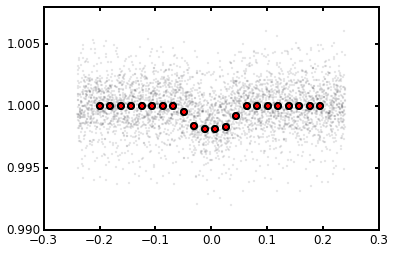

In [58]:
plt.plot(tfold[close], flux[close], 'o', ms=0.2, alpha=0.35);
t = np.arange(-0.2, 0.2, KEPLER_CADENCE)
f = model.light_curve(params, t)
plt.plot(t, f, 'ro');

In [48]:
f

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  0.99951293,  0.99839263,
        0.99815823,  0.99813884,  0.998298  ,  0.9991491 ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ])